> Team Members: Sagun Karki

# Table of Contents
- [2. Load and Preprocess Data](#load-and-preprocess-data)
- [3. Model Training](#model-training)
- [4. Model Evaluation](#compare-model-perfromance)
  - [4.1 Actual Vs Predicted](##actual-vs-predicted-price)
  - [3.2 Metrics Comparision Plot](##metrics-comparison-plot)
- [5. Feature Importance](#what-features-contribute-to-the-most-for-the-price-of-the-cab)


In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.linear_model import LinearRegression

# Load and Preprocess Data

In [2]:
df_cab_rides = pd.read_csv('../data/cab_rides.csv')
df_weather = pd.read_csv('../data/weather.csv')

In [3]:
df_cab_rides.head()

,distance,cab_type,time_stamp,destination,source,price,surge_multiplier,id,product_id,name
0,0.44,Lyft,1544952607890,North Station,Haymarket Square,5.0,1.0,424553bb-7174-41ea-aeb4-fe06d4f4b9d7,lyft_line,Shared
1,0.44,Lyft,1543284023677,North Station,Haymarket Square,11.0,1.0,4bd23055-6827-41c6-b23b-3c491f24e74d,lyft_premier,Lux
2,0.44,Lyft,1543366822198,North Station,Haymarket Square,7.0,1.0,981a3613-77af-4620-a42a-0c0866077d1e,lyft,Lyft
3,0.44,Lyft,1543553582749,North Station,Haymarket Square,26.0,1.0,c2d88af2-d278-4bfd-a8d0-29ca77cc5512,lyft_luxsuv,Lux Black XL
4,0.44,Lyft,1543463360223,North Station,Haymarket Square,9.0,1.0,e0126e1f-8ca9-4f2e-82b3-50505a09db9a,lyft_plus,Lyft XL


In [4]:
df_weather.head()

,temp,location,clouds,pressure,rain,time_stamp,humidity,wind
0,42.42,Back Bay,1.0,1012.14,0.1228,1545003901,0.77,11.25
1,42.43,Beacon Hill,1.0,1012.15,0.1846,1545003901,0.76,11.32
2,42.50,Boston University,1.0,1012.15,0.1089,1545003901,0.76,11.07
3,42.11,Fenway,1.0,1012.13,0.0969,1545003901,0.77,11.09
4,43.13,Financial District,1.0,1012.14,0.1786,1545003901,0.75,11.49


In [5]:
df_cab_rides.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 693071 entries, 0 to 693070
Data columns (total 10 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   distance          693071 non-null  float64
 1   cab_type          693071 non-null  object 
 2   time_stamp        693071 non-null  int64  
 3   destination       693071 non-null  object 
 4   source            693071 non-null  object 
 5   price             637976 non-null  float64
 6   surge_multiplier  693071 non-null  float64
 7   id                693071 non-null  object 
 8   product_id        693071 non-null  object 
 9   name              693071 non-null  object 
dtypes: float64(3), int64(1), object(6)
memory usage: 52.9+ MB


In [6]:
df_weather.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6276 entries, 0 to 6275
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   temp        6276 non-null   float64
 1   location    6276 non-null   object 
 2   clouds      6276 non-null   float64
 3   pressure    6276 non-null   float64
 4   rain        894 non-null    float64
 5   time_stamp  6276 non-null   int64  
 6   humidity    6276 non-null   float64
 7   wind        6276 non-null   float64
dtypes: float64(6), int64(1), object(1)
memory usage: 392.4+ KB


In [7]:
df_cab_rides.isna().sum()

distance                0
cab_type                0
time_stamp              0
destination             0
source                  0
price               55095
surge_multiplier        0
id                      0
product_id              0
name                    0
dtype: int64

In [8]:
print("Percentage of missing values in 'price' column: ", end = '')
print(round(df_cab_rides['price'].isna().sum() / len(df_cab_rides) * 100, 2), "%")

Percentage of missing values in 'price' column: 7.95 %


we will drop missing rows in the `price` column. Becuase even after dropping them we will have enough data to train our model.

In [9]:
df_cab_rides.dropna(subset=['price'], inplace=True)

In [10]:
df_weather.isna().sum()

temp             0
location         0
clouds           0
pressure         0
rain          5382
time_stamp       0
humidity         0
wind             0
dtype: int64

In [11]:
print("Percentage of missing values in 'rain' column: ", end = '')
print(round(df_weather['rain'].isna().sum() / len(df_weather) * 100, 2), "%")

Percentage of missing values in 'rain' column: 85.76 %


Almost all of the data in column rain are missing. There are no good imputation methods for this column. So we will drop the column `rain`.

In [12]:
df_weather.drop(columns=['rain'], inplace=True)

fix datetime, the datetime are in different units and formats.


In [13]:
df_cab_rides['time_stamp'] = pd.to_datetime(df_cab_rides['time_stamp'], unit='ms').dt.floor('s')
df_weather['time_stamp'] = pd.to_datetime(df_weather['time_stamp'], unit='s')

### Join Weather data to cab price dataset

The person goes from `source` to `destination` location. We will search weather within 30 minutes of the trip in location of `source`. We will join that weather data to the cab price dataset.

For example: if we have a row with trip start time of '2018-11-01 10:00:00' and `source` location *A* and we find a weather data for *A* at '2018-11-01 10:12:00' then we will join that row with the cab price dataset. *try to find the closest weather within 30 minutes of the trip start time*.


In [14]:
df_merged = []

for location, df_loc in df_cab_rides.groupby('source'):
    df_weather_loc = df_weather[df_weather['location'] == location]

    df_loc = df_loc.sort_values(by='time_stamp')
    df_weather_loc = df_weather_loc.sort_values(by='time_stamp')

    merged = pd.merge_asof(
        df_loc,
        df_weather_loc,
        on='time_stamp',
        direction='nearest',
        tolerance=pd.Timedelta('30min')
    )
    df_merged.append(merged)


# Model Training

## Split the data into train and test set

In [15]:
df_merged = pd.concat(df_merged, ignore_index=True)

In [16]:
df_merged.groupby('source')['clouds'].agg(lambda x: x.isna().sum())


source
Back Bay                   103
Beacon Hill                 86
Boston University          170
Fenway                     185
Financial District         136
Haymarket Square           161
North End                  116
North Station              144
Northeastern University    166
South Station              168
Theatre District           125
West End                   125
Name: clouds, dtype: int64

While merging the weather, around 150 rows for each city will have missing values for weather. The time range for weather data and trip data might be different. We can **drop those rows**. We will have enough data to train our model.

In [17]:

df = df_merged.copy()
df = df.dropna()

### Encode the categorical variables to numerical variables

In [18]:
label_encoders = {}
categorical_cols = ['cab_type', 'destination', 'source', 'id', 'product_id', 'name', 'location']
for col in categorical_cols:
    label_encoders[col] = LabelEncoder()
    df[col] = label_encoders[col].fit_transform(df[col])

# Extract numerical features from the timestamp
df['hour'] = df['time_stamp'].dt.hour
df['dayofweek'] = df['time_stamp'].dt.dayofweek
df['month'] = df['time_stamp'].dt.month

df.drop('time_stamp', axis=1, inplace=True)


### Select the features and target variable

In [19]:
# Select features and target
features = ['distance', 'cab_type', 'hour', 'dayofweek', 'month', 'destination', 'source', 'surge_multiplier', 'product_id', 'temp', 'location', 'clouds', 'pressure', 'humidity', 'wind']
target = 'price'

X = df[features]
y = df[target]

### 80-20 split of the data

In [20]:
# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


## Model 1: Linear Regression

In [21]:


lr_model = LinearRegression()
lr_model.fit(X_train, y_train)


LinearRegression()

## Model 2: Random Forest Regressor

In [22]:
rfr_model = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)
rfr_model.fit(X_train, y_train)

RandomForestRegressor(n_jobs=-1, random_state=42)

# Compare Model Perfromance

Between the two models tested, 
Random Forest Regressor outperforms Linear Regression across all evaluation metrics. 
It achieves significantly lower MSE, RMSE, and MAE, and a much higher R² score, while testing on *test set* capturing the details of data.
This is expected, as Random Forest can model complex, nonlinear relationships and interactions that Linear Regression cannot. 









In [23]:

def evaluate_model(model, X_test, y_test):
    """
    Evaluate the model using various metrics.
    """
    predictions = model.predict(X_test)
    mse = mean_squared_error(y_test, predictions)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test, predictions)
    mae = mean_absolute_error(y_test, predictions)

    return {
        'MSE': round(mse, 2),
        'RMSE': round(rmse, 2),
        'R2': round(r2, 2),
        'MAE': round(mae, 2)
    }


def plot_models_actual_vs_predicted(models, model_names, X_test, y_test):
    plt.figure(figsize=(12, 6))
    
    for i, (model, name) in enumerate(zip(models, model_names), 1):
        y_pred = model.predict(X_test)
        plt.subplot(1, 2, i)
        plt.scatter(y_test, y_pred, alpha=0.3)
        plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
        plt.xlabel('Actual Price')
        plt.ylabel('Predicted Price')
        plt.title(f'{name}: Actual vs Predicted')
        plt.grid(True)
    
    plt.tight_layout()
    plt.show()



## Actual vs Predicted Price

The Random Forest model predicts prices much more accurately than the Linear Regression model, as its points align closer to the red diagonal line (perfect prediction)

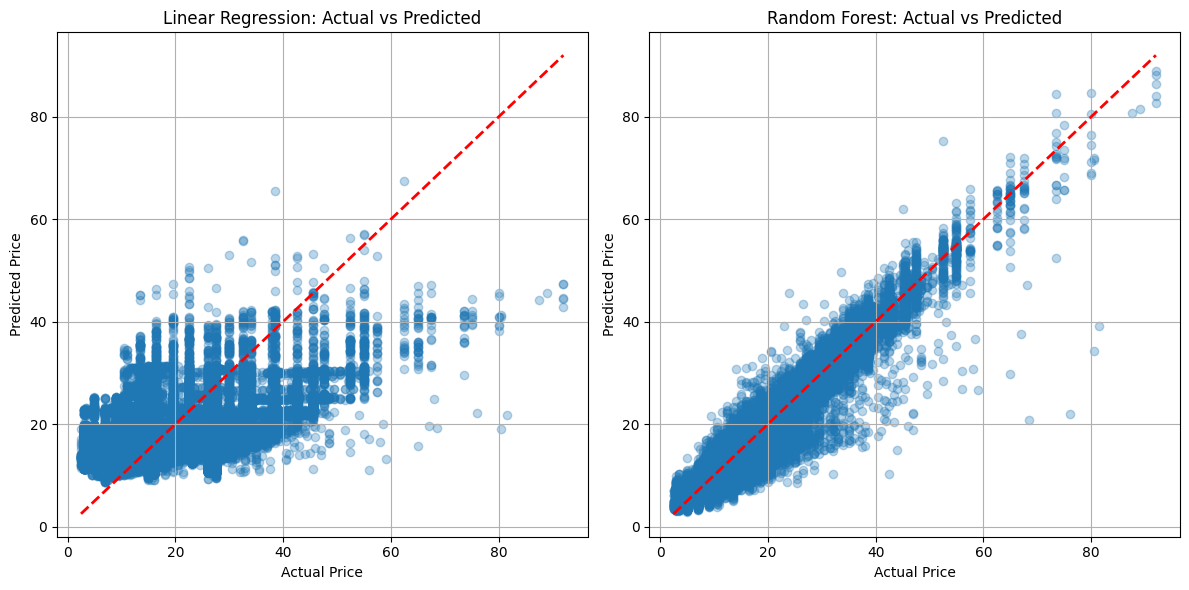

In [24]:
plot_models_actual_vs_predicted([lr_model, rfr_model], ['Linear Regression', 'Random Forest'], X_test, y_test)


## Metrics Comparison Plot

Based on the results, Random Forest Regressor performs better than Linear Regression model to predict price. 

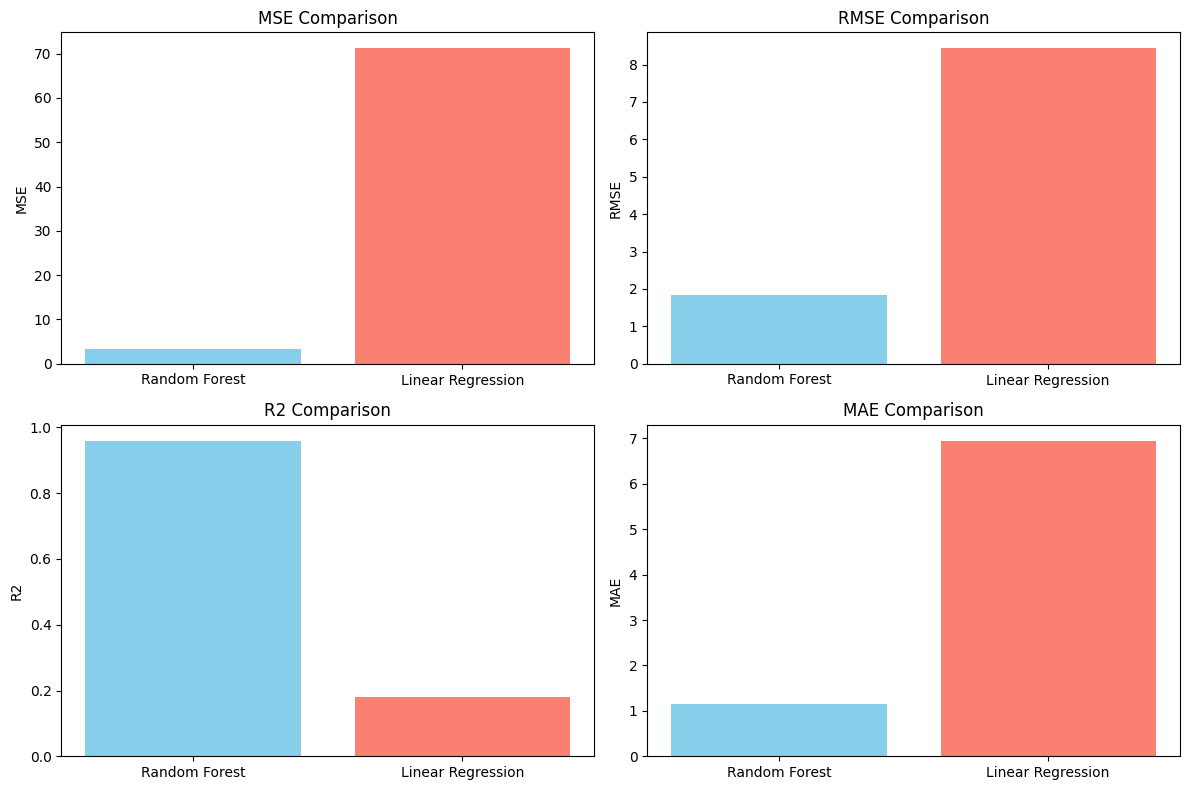

In [25]:
res_lr = evaluate_model(lr_model, X_test, y_test)
res_rfr = evaluate_model(rfr_model, X_test, y_test)

df = pd.DataFrame([res_rfr, res_lr], index=['Random Forest', 'Linear Regression'])
df = df[['MSE', 'RMSE', 'R2', 'MAE']]


metrics = df.columns
models = df.index
colors = ['skyblue', 'salmon']

fig, axes = plt.subplots(2, 2, figsize=(12, 8))
axes = axes.flatten()

for i, metric in enumerate(metrics):
    axes[i].bar(models, df[metric], color=colors)
    axes[i].set_title(f'{metric} Comparison')
    axes[i].set_ylabel(metric)
    axes[i].tick_params(axis='x', rotation=0)
    axes[i].grid(False)

plt.tight_layout()
plt.show()



In [26]:
df.reset_index().to_csv("../data/metrics.csv", index=False)

# What features contribute to the most for the price of the cab

The Random Forest model identifies **`product_id`** and **`distance`** as the most important features in predicting cab prices. These two features dominate the model's decision-making process, while other variables like weather conditions, time, and location have negligible influence.


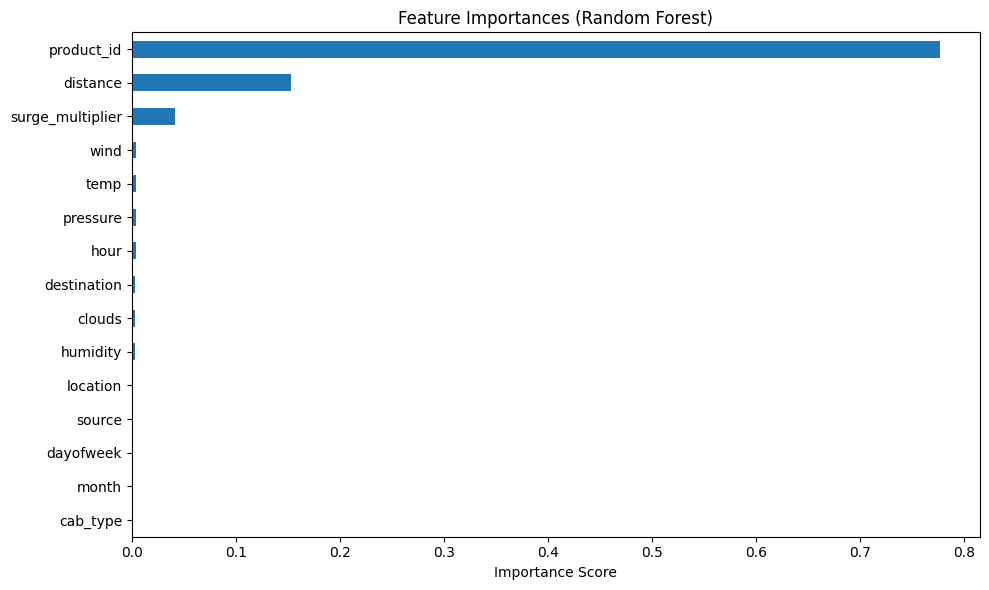

In [27]:
importances = rfr_model.feature_importances_
feat_names = X.columns

feat_imp = pd.Series(importances, index=feat_names).sort_values(ascending=False)

# Plot
plt.figure(figsize=(10, 6))
feat_imp.plot(kind='barh')
plt.title('Feature Importances (Random Forest)')
plt.xlabel('Importance Score')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()